In [1]:
from os.path import isdir, join
import pickle
import numpy as np
import matplotlib.pyplot as plt
# import rosbag
import glob
from sklearn.model_selection import train_test_split, KFold
import os
import pdb
import math
import torch
from os.path import join
from mpl_toolkits.mplot3d import Axes3D

In [2]:
dataset_filename = "multi_intention_dataset_slow.p"
dataset_filepath = join('Dataset', dataset_filename)
with open(dataset_filepath,'rb') as f:
    u = pickle._Unpickler( f )
    u.encoding = 'latin1'
    raw_data = u.load()
    


In [3]:
data = {}
for intention, traj in zip(raw_data['intentions'], raw_data['trajs']):
    if intention not in data.keys():
        data[intention] = []
    traj = torch.from_numpy(traj).float()*100.
    data[intention].append(traj)

In [4]:
data[1] = data[2]

In [5]:
data.keys()

dict_keys([2, 1, 0])

/home/hcalab/Desktop/MYJ/FIT/HumanIntention/myenv/lib/python3.6/site-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


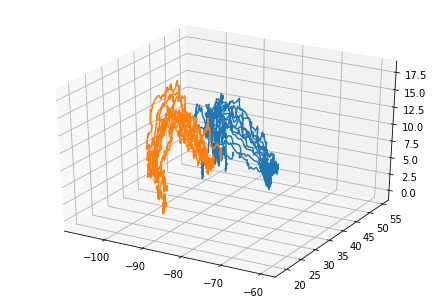

In [6]:
%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)
# ax.axis('equal')
for intention in [0,1]:
    color_traj = 'C'+str(intention)
    for traj in data[intention]:
        ax.plot(traj[:,0],traj[:,1],traj[:,2], c=color_traj)
plt.show()

In [7]:
xtrain, xtest, ytrain, ytest = [], [], [], []
for intention in [0, 1]:
    intention_label = [intention for i in range(len(data[intention]))]
    xtraini, xtesti, ytraini, ytesti = train_test_split(data[intention], intention_label, test_size=5, random_state=0)
    xtrain += xtraini
    ytrain += ytraini
    xtest += xtesti
    ytest += ytesti

In [8]:
def process_data(raw_x, raw_y, obs_seq_len, pred_seq_len, skip=2):
    seq_len = obs_seq_len+pred_seq_len
    xobs, xpred, yintention = [], [], []
    for x, y in zip(raw_x, raw_y):
        n_seq = math.floor((len(x)-seq_len)/skip)+1
        idx_range = range(0, n_seq*skip, skip)
        for idx in idx_range:
            seq_data = x[idx:idx+seq_len]# (seq_len, 2)
            obs_seq_data, pred_seq_data = seq_data[:obs_seq_len], seq_data[obs_seq_len:]
            xobs.append(obs_seq_data)
            xpred.append(pred_seq_data)
            yintention.append(y)
            
    xobs = torch.stack(xobs, dim=0) # (N, obs_seq_len, 2)
    xpred = torch.stack(xpred, dim=0) # (N, pred_seq_len, 2)
    yintention = torch.tensor(yintention).unsqueeze(1).type(torch.float) # (N, 1)
    return xobs, xpred, yintention

skip = 1
obs_seq_len, pred_seq_len = 20, 20 #4, 6

xobs_train, xpred_train, yintention_train = process_data(xtrain, ytrain, obs_seq_len, pred_seq_len, skip=skip)
xobs_test, xpred_test, yintention_test = process_data(xtest, ytest, obs_seq_len, pred_seq_len, skip=skip)

In [9]:
torch.save({"xobs_train": xobs_train, "xpred_train": xpred_train, "yintention_train": yintention_train,\
            "xobs_test": xobs_test, "xpred_test": xpred_test, "yintention_test": yintention_test, \
            "obs_seq_len": obs_seq_len, "pred_seq_len": pred_seq_len, "skip": skip}, 'short_prediction_multi_intention_data_slow.pt')





In [10]:
print(sum(yintention_train==0))
print(sum(yintention_train==1))

tensor([801])
tensor([838])


In [11]:
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for train_index, validation_index in kf.split(xobs_train):
#     print("TRAIN:", train_index, "VAL:", validation_index)
    print(xobs_train[train_index][20])
    print(sum(yintention_train[validation_index]==0))
    print(sum(yintention_train[validation_index]==1))
    print(sum(yintention_train[validation_index]==2))
    print()
    break

tensor([[-98.5481,  51.3827,   4.2647],
        [-98.3726,  51.1576,   4.6078],
        [-98.1226,  50.8906,   5.2858],
        [-97.9986,  50.7658,   5.6015],
        [-97.8051,  50.5799,   6.2081],
        [-97.9819,  50.5890,   5.5760],
        [-97.9951,  50.1640,   5.5232],
        [-97.7626,  49.6981,   6.3243],
        [-97.8813,  49.5336,   5.9223],
        [-97.6948,  49.2182,   5.9689],
        [-97.7582,  48.7173,   5.4067],
        [-97.2828,  47.9754,   6.8857],
        [-97.0586,  47.6354,   7.0060],
        [-97.0074,  47.5614,   6.8423],
        [-96.7976,  47.2144,   7.4319],
        [-96.6999,  47.0624,   7.7474],
        [-96.3542,  46.8849,   8.3813],
        [-96.4391,  46.7275,   7.7835],
        [-96.2371,  46.5653,   7.7641],
        [-95.9694,  46.3329,   7.7291]])
tensor([156])
tensor([172])
tensor([0])

